<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [16]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from glob import iglob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import re
import math
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [109]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    dictionary = {}
    gen_data_ar = []#np.array([], dtype=int)
    next_session_id = 1
    next_word_id = 1
    
    cols = ['session_id']
    #new_cols = ['site' + str(i) for i in np.arange(session_length)]
    for c in feature_names:
      cols.append(c)
    #cols.append('user_id')
    gen_data = pd.DataFrame(columns = cols)
    
    for file_num, filepath in tqdm_notebook(enumerate(iglob(path_to_csv_files))):
        with open(filepath) as f:
            data = pd.read_csv(f, parse_dates = ['timestamp'])
            user_id = int(re.search('user(\d+).csv', filepath).group(1))
            loop_count = int(math.ceil(len(data) / window_size))
            for i in np.arange(loop_count):
                chunck_ar = np.zeros(len(feature_names) + 1 , dtype = int)
                chunck_ar[0] = next_session_id
                session_sites = data['site'].values[i * window_size : i * window_size + session_length]
                for site in session_sites:
                    if site in dictionary:
                        dictionary[site] = (dictionary[site][0], dictionary[site][1] + 1)
                    else:
                        dictionary[site] = (next_word_id ,1)
                        next_word_id += 1
                sessioin_sites_ids = list(map(lambda x : dictionary[x][0], session_sites))
                chunck_ar[1:len(sessioin_sites_ids)+1] = sessioin_sites_ids
                
                
                timestamps = data['timestamp'].values[i * window_size : i * window_size + session_length]
                
                time_diff = [int((timestamps[i + 1] - timestamps[i]) / 1e9) for i, t in enumerate(timestamps) if i != len(timestamps) - 1]
                
                chunck_ar[session_length + 1 : session_length + 1 + len(time_diff)] = time_diff
                
                chunck_ar[session_length + session_length] = int((timestamps[-1] - timestamps[0]) / 1e9)
                
                chunck_ar[session_length + 1 + session_length] = len(list(set(sessioin_sites_ids)))
                
                chunck_ar[session_length + 2 + session_length] = pd.to_datetime(timestamps[0]).hour
                chunck_ar[session_length + 3 + session_length] = pd.to_datetime(timestamps[0]).dayofweek
                
                chunck_ar[-1] = user_id
                next_session_id += 1
                gen_data_ar.append(chunck_ar)#np.append(gen_data_ar, chunck_ar)

    gen_data_ar = np.array(gen_data_ar).reshape(next_session_id - 1, len(feature_names) + 1)
    #cols = ['session_id']
    #new_cols = ['site' + str(i) for i in np.arange(10)]
    #for c in new_cols:
      #cols.append(c)
    #cols.append('user_id')
    gen_data = pd.DataFrame(data = gen_data_ar, columns = cols)
    gen_data = gen_data.set_index('session_id')

    return gen_data, dictionary

In [134]:
#import datetime
data = pd.read_csv('capstone_user_identification/3users/user0001.csv', parse_dates = ['timestamp'], infer_datetime_format=True)
print(data.dtypes)
#print((datetime.datetime.strptime(data['timestamp'][1], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(data['timestamp'][0], '%Y-%m-%d %H:%M:%S')).seconds)# - data['timestamp'][0])
#print(datetime.datetime.strptime(data['timestamp'], '%Y-%m-%d %H:%M:%S'))

timestamp    datetime64[ns]
site                 object
dtype: object


**Проверим функцию на игрушечном примере.**

In [89]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('capstone_user_identification/3users/user*.csv', 
                  site_freq_path='capstone_user_identification/site_freq_3users.pkl',
                  feature_names=feature_names, session_length=10)

A Jupyter Widget

In [83]:
train_data_toy[0]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
session_id,,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
2,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
3,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
4,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
5,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [87]:
train_data_10users[0].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
session_id,,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
2,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
3,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
4,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
5,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [160]:
%%time
train_data_10users = prepare_train_set_with_fe('capstone_user_identification/10users/user*.csv', 
                  site_freq_path='capstone_user_identification/site_freq_10users.pkl',
                  feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 2.79 s


In [417]:
train_data_10users[0][:5]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
session_id,,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,John
2,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,John
3,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,John
4,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,John
5,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,John


In [135]:
%%time
train_data_150users = prepare_train_set_with_fe('capstone_user_identification/150users/user*.csv', 
                  site_freq_path='capstone_user_identification/site_freq_150users.pkl',
                  feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 26.2 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [143]:
new_features_10users = train_data_10users[0][['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[0][['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [144]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [153]:
users10_info =  new_features_10users.describe()
print(users10_info['session_timespan']['50%'])

37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [154]:
print(users10_info['day_of_week']['50%'])

2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [155]:
print(users10_info['start_hour']['50%'])

14.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [157]:
print(users10_info['#unique_sites']['50%'])

6.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [166]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users[0]['target'] = train_data_10users[0]['target'].map(id_name_dict)

In [167]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

(array([ 1882.,  1296.,   954.,   706.,   537.,   467.,   344.,   400.,
          352.,   295.,   267.,   377.,   304.,   327.,   288.,   382.,
          249.,   185.,   124.,   106.,   118.,    94.,    78.,    80.,
           75.,    67.,    44.,    61.,    60.,    49.,    50.,    64.,
           51.,    47.,    44.,    36.,    37.,    58.,    43.,    43.,
           37.,    38.,    40.,    52.,    52.,    48.,    24.,    29.,
           22.,    31.]),
 array([   0.,    4.,    8.,   12.,   16.,   20.,   24.,   28.,   32.,
          36.,   40.,   44.,   48.,   52.,   56.,   60.,   64.,   68.,
          72.,   76.,   80.,   84.,   88.,   92.,   96.,  100.,  104.,
         108.,  112.,  116.,  120.,  124.,  128.,  132.,  136.,  140.,
         144.,  148.,  152.,  156.,  160.,  164.,  168.,  172.,  176.,
         180.,  184.,  188.,  192.,  196.,  200.]),
 <a list of 50 Patch objects>)

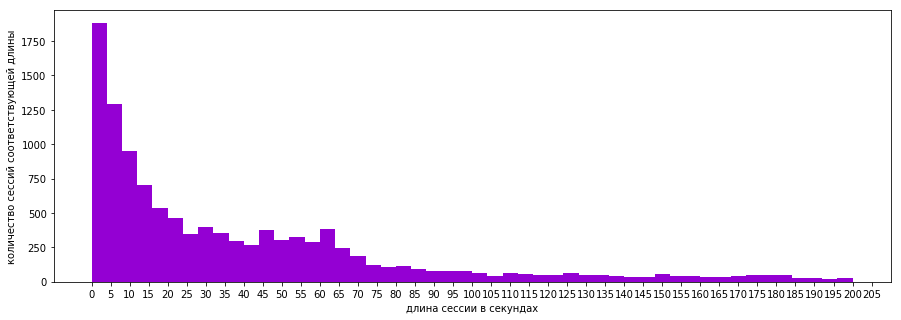

In [264]:
#plt.hist(train_data_10users[0]['session_timespan'])
fig = plt.figure(figsize = (15, 5))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim(0, 200)
ax.set_xlabel('длина сессии в секундах')
ax.set_ylabel('количество сессий соответствующей длины')
ax.xaxis.set_ticks(np.arange(0, 210, 5))
ax.hist([x for x in train_data_10users[0]['session_timespan'].values if x <= 200], bins = 50, color = 'darkviolet')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

(array([  428.,  1249.,   890.,  1163.,  1735.,  2199.,  2307.,  2045.,
         1394.,   651.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

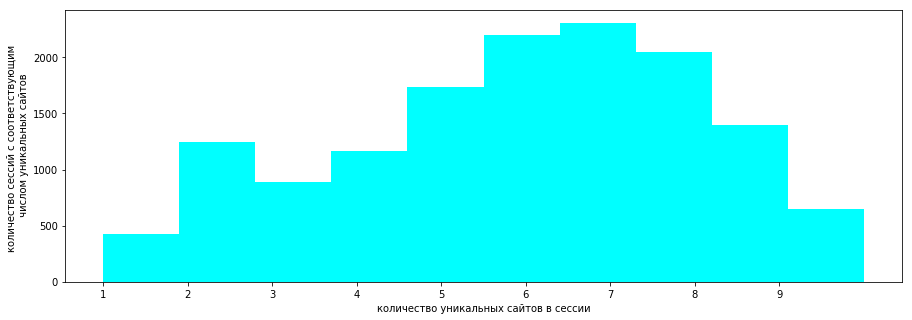

In [270]:
fig = plt.figure(figsize = (15, 5))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim(0, 200)
ax.set_xlabel('количество уникальных сайтов в сессии')
ax.set_ylabel('количество сессий с соответствующим \n числом уникальных сайтов')
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.hist(train_data_10users[0]['#unique_sites'].values, color = 'aqua')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

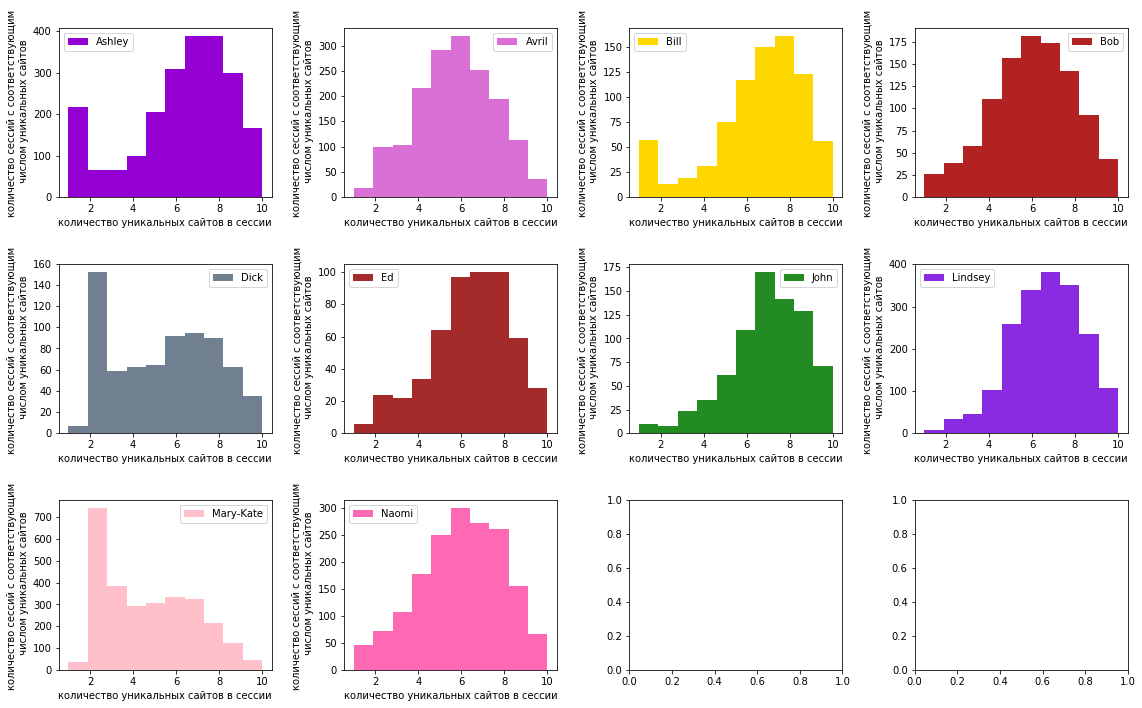

In [284]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users[0], 'target')): 
     plt.subplot(3, 4, idx + 1)
     plt.hist(sub_df['#unique_sites'].values, color = color_dic[user])
     plt.legend((user,))
     plt.xlabel('количество уникальных сайтов в сессии')
     plt.ylabel('количество сессий с соответствующим \n числом уникальных сайтов')
plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

(array([  775.,  2561.,   920.,  2443.,  1872.,  2356.,  1379.,   456.,
          942.,   357.]),
 array([  7. ,   8.6,  10.2,  11.8,  13.4,  15. ,  16.6,  18.2,  19.8,
         21.4,  23. ]),
 <a list of 10 Patch objects>)

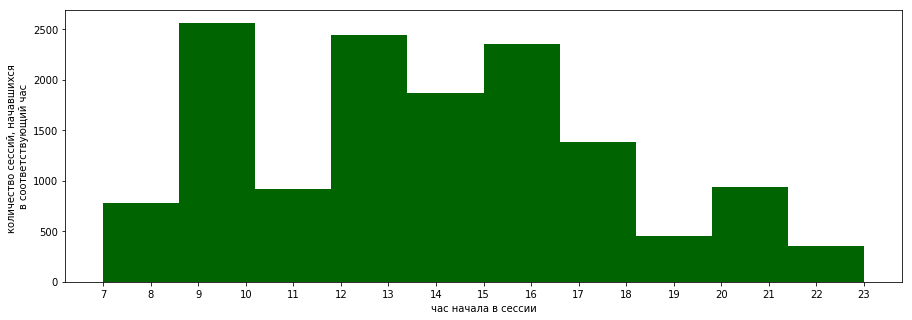

In [286]:
fig = plt.figure(figsize = (15, 5))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim(0, 200)
ax.set_xlabel('час начала в сессии')
ax.set_ylabel('количество сессий, начавшихся \nв соответствующий час')
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.hist(train_data_10users[0]['start_hour'].values, color = 'darkgreen')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

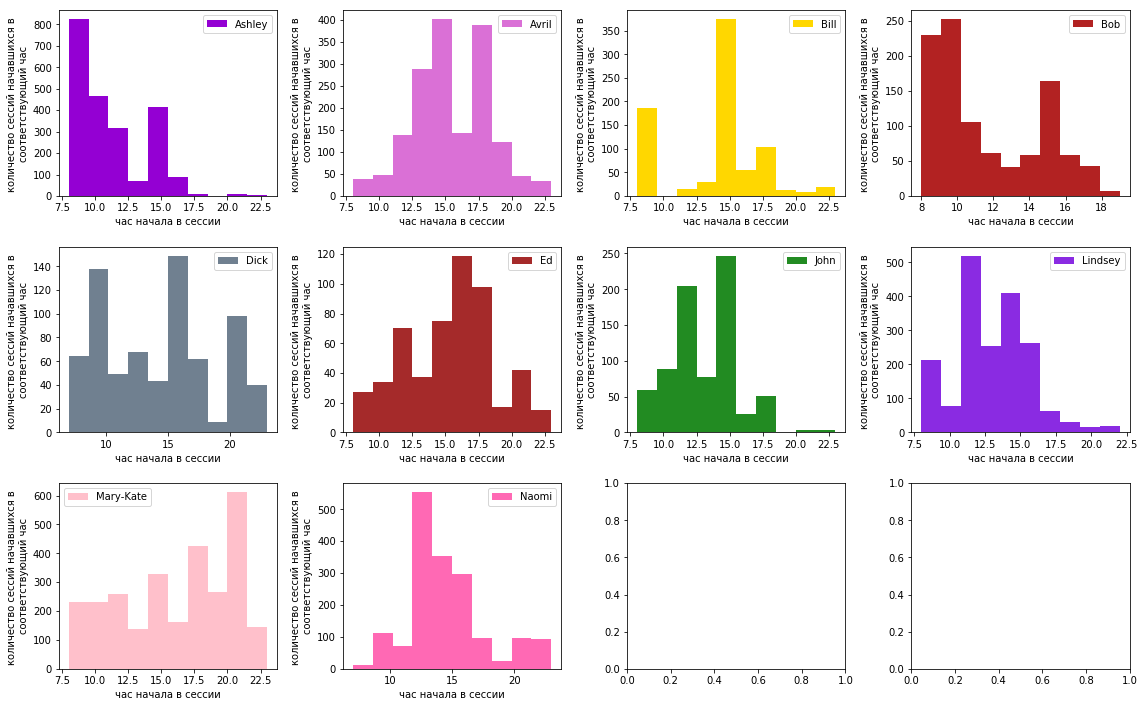

In [290]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users[0], 'target')): 
     plt.subplot(3, 4, idx + 1)
     plt.hist(sub_df['start_hour'].values, color = color_dic[user])
     plt.legend((user,))
     plt.xlabel('час начала в сессии')
     plt.ylabel('количество сессий начавшихся в \nсоответствующий час')
plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

(array([ 1505.,  2772.,     0.,  3163.,     0.,  2316.,  1520.,     0.,
         1494.,  1291.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

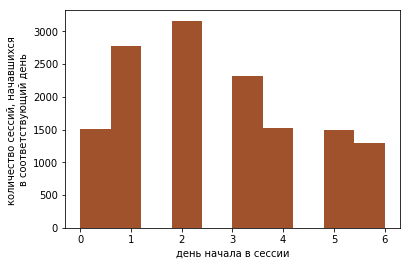

In [418]:
fig = plt.figure()#figsize = (15, 5))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim(0, 200)
ax.set_xlabel('день начала в сессии')
ax.set_ylabel('количество сессий, начавшихся \nв соответствующий день')
ax.xaxis.set_ticks(np.arange(0, 7, 1))
ax.hist(train_data_10users[0]['day_of_week'].values, color = 'sienna')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

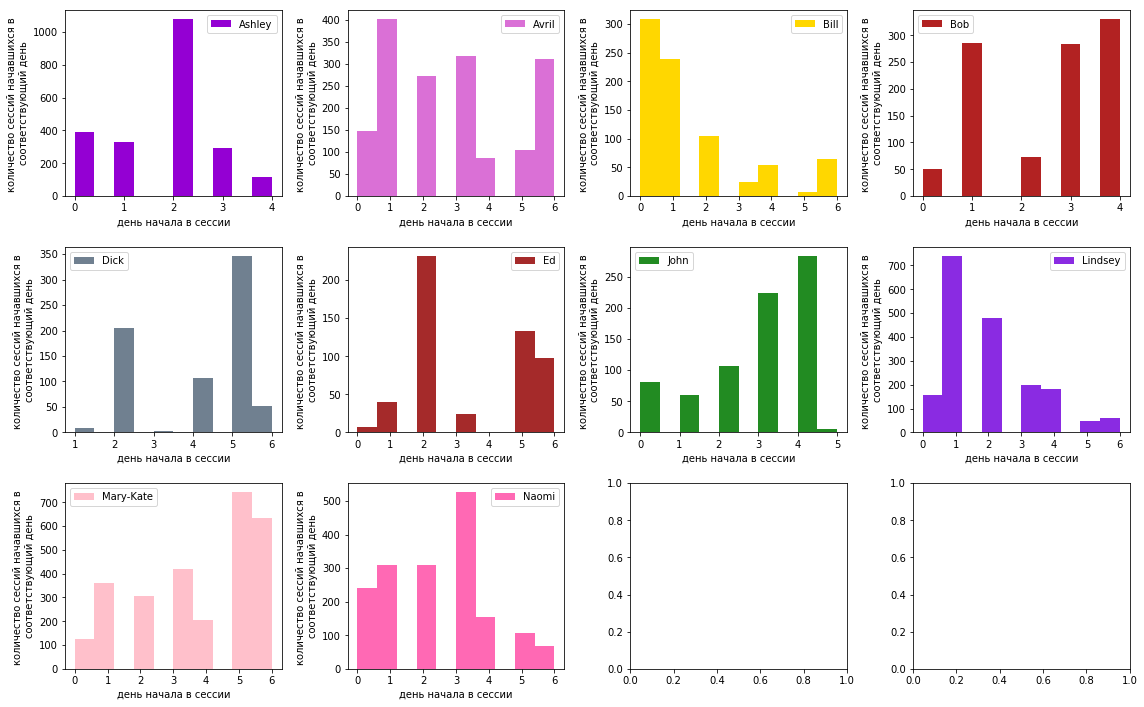

In [295]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users[0], 'target')): 
     plt.subplot(3, 4, idx + 1)
     plt.hist(sub_df['day_of_week'].values, color = color_dic[user])
     plt.legend((user,))
     plt.xlabel('день начала в сессии')
     plt.ylabel('количество сессий начавшихся в \nсоответствующий день')
plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''
Количество уникальных сайтов в сессии:
Dick и Mary-Kate чаще всего посещают всего 2  уникальных сайта. Остальные пользователи - в среднем 6-7 уникальных сайтов.
У пользователей Ashley и Bill также есть тяжелый левый хвост, то есть велико количество сессий, в которых они посещают всего два уникальных сайта. В остальном распределения количества уникальных сайтов в сессии внешне похожи на нормальные с математическим ожиданием [6-8].
График часа начала сессии:
Ashley начинает сессию чаще всего в 8 утра, и дальше идет по нисподающей, то есть она предпочитает первую половину дня для начала серфа. Avril начинает сессию чаще всего около 15 или около 17 часов дня и примерно одинаково отклоняется в обе стороны (начинает раньше или позже) от этих цифр, т.е. ее распределение часа начала походит на нормальное. Bill начинает около 8 или около 15 часов дня и крайне редко в любое другое время. Bob предпочитает начинать до 10 часов утра или около 16 часов дня, остальное время для него не слишком популярно для начала сессии. У Dicka есть выраденные пики в 9 утра, 15 дня и 21 вечера.
 Распределение часа начала сессии у Ed-а походит на нормальное с МО = 16 часам, отклонения в сторону более раннего или более позднего начала сессии примерно одинаковы. John начинает чаще всего в 11 или в 15, и реже в  другое время, начать после 18 для него почти невозможно. Основные часы начала у Lindsey приходятся на промежуток с 11 до 16. У MaryKate есть тенденция к тому, чтобы начинать позже, чаще всего после 20. Naomi чаще всего начинает с 11 до 16
 -----
 Почему-то никто не начинает серфить в промежутке от 23 до 7 утра. Час начала сессии достаточно уникален для каждого человека, кто-то начинает раньше, кто-то позже, поэтому данный признак может быть достаточно информативным в вопросе идентификации пользователя
 График дня начала сессии:
 Ashley начинает только в будни, чаще всего в среду. Avril предпочитает начинать во вторник, серду, четверг или воскресенье. Bill в понедельник или вторник. Bill во вторник, четверг пятницу. Dick в среду и субботу. Ed в среду, субботу, воскресенье. John к концу 

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [302]:
with open('capstone_user_identification/X_sparse_10users.pkl', 'rb') as f:
    freq_dic = pickle.load(f)

In [426]:
s = freq_dic.sum(axis = 0)
s_arg = s.argsort(axis = 1)
top_10_sites_codes = s_arg[:, -10:]
top_10_freqs = s[0, s_arg[:, -10:]]
print(s)
print(s_arg)
print(top_10_sites_codes)
print(top_10_freqs)
print(s_arg.max())
sites_names = [d_k for i in top_10_sites_codes.tolist()[0] for d_k, d_v in train_data_10users[1].items() if d_v[0] == i + 1]
print(sites_names)

[[ 88  23 119 ...,   4   7   1]]
[[4912 4547 1489 ...,    3   50  209]]
[[183 186 213 699  51  14 182   3  50 209]]
[[2089 2630 3094 3244 3758 4141 4158 5441 7813 8300]]
4912
['accounts.google.com', 'plus.google.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'apis.google.com', 'www.facebook.com', 'mail.google.com', 'www.google.com', 'www.google.fr', 's.youtube.com']


In [512]:
with open('capstone_user_identification/X_sparse_150users.pkl', 'rb') as f:
    freq_dic_150 = pickle.load(f)
s = freq_dic_150.sum(axis = 0)
s_arg = s.argsort(axis = 1)
top_10_sites_codes_150u = s_arg[:, -10:]
top_10_freqs_150u = s[0, s_arg[:, -10:]]
print(s)
print(s_arg)
print(top_10_sites_codes_150u)
print(top_10_freqs_150u)
print(s_arg.max())
sites_names_150u = [d_k for i in top_10_sites_codes_150u.tolist()[0] for d_k, d_v in train_data_150users[1].items() if d_v[0] == i + 1]
print(sites_names_150u)

[[64785 29983 51320 ...,     2     1     1]]
[[13898 16296 16297 ...,    40     2     0]]
[[104 292  26  27 213 180   1  40   2   0]]
[[16319 17960 18467 19072 25087 29102 29983 39002 51320 64785]]
27796
['www.youtube.com', 'safebrowsing-cache.google.com', 'plus.google.com', 'mail.google.com', 'clients1.google.com', 's.youtube.com', 'apis.google.com', 'www.facebook.com', 'www.google.com', 'www.google.fr']


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [427]:
top10_freqs = top_10_freqs.tolist()[0] #''' ВАШ КОД ЗДЕСЬ '''
top10_sites = sites_names #''' ВАШ КОД ЗДЕСЬ '''

In [513]:
top10_freqs_150u = top_10_freqs_150u.tolist()[0] #''' ВАШ КОД ЗДЕСЬ '''
top10_sites_150u = sites_names_150u #''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

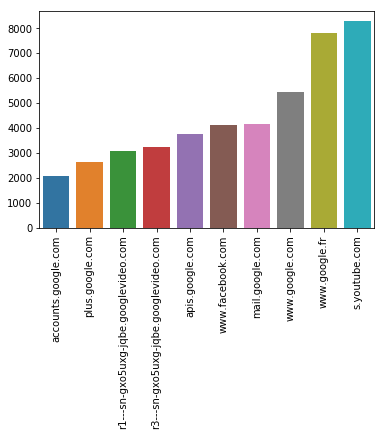

In [429]:
g = sns.barplot(sites_names, top10_freqs) # ''' ВАШ КОД ЗДЕСЬ '''
g.set_xticklabels(sites_names, rotation=90)
#plt.xticks(rotation=45)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [528]:
def feature_engineering(path_to_csv_files, site_freq_path, features, top_sites_codes, session_length=10, window_size = 10):
    dictionary = {}
    gen_data_ar = []#np.array([], dtype=int)
    next_session_id = 1
    next_word_id = 1
    
    cols = ['session_id']
    #new_cols = ['site' + str(i) for i in np.arange(session_length)]
    for c in features:
      cols.append(c)
    #cols.append('user_id')
    gen_data = pd.DataFrame(columns = cols)
    
    for file_num, filepath in tqdm_notebook(enumerate(iglob(path_to_csv_files))):
        with open(filepath) as f:
            data = pd.read_csv(f, parse_dates = ['timestamp'])
            user_id = int(re.search('user(\d+).csv', filepath).group(1))
            loop_count = int(math.ceil(len(data) / window_size))
            for i in np.arange(loop_count):
                chunck_ar = np.zeros(len(features) + 1 , dtype = float)
                chunck_ar[0] = next_session_id
                session_sites = data['site'].values[i * window_size : i * window_size + session_length]
                for site in session_sites:
                    if site in dictionary:
                        dictionary[site] = (dictionary[site][0], dictionary[site][1] + 1)
                    else:
                        dictionary[site] = (next_word_id ,1)
                        next_word_id += 1
                sessioin_sites_ids = list(map(lambda x : dictionary[x][0], session_sites))
                chunck_ar[1:len(sessioin_sites_ids)+1] = sessioin_sites_ids
                
                
                timestamps = data['timestamp'].values[i * window_size : i * window_size + session_length]
                
                time_diff = [int((timestamps[i + 1] - timestamps[i]) / 1e9) for i, t in enumerate(timestamps) if i != len(timestamps) - 1]
                
                chunck_ar[session_length + 1 : session_length + 1 + len(time_diff)] = time_diff
                
                chunck_ar[session_length + session_length] = int((timestamps[-1] - timestamps[0]) / 1e9)
                
                chunck_ar[session_length + 1 + session_length] = len(list(set(sessioin_sites_ids)))
                
                chunck_ar[session_length + 2 + session_length] = pd.to_datetime(timestamps[0]).hour
                chunck_ar[session_length + 3 + session_length] = pd.to_datetime(timestamps[0]).dayofweek
                
                #частота посещения топ-10 сайтов за сессию
                chunck_ar[session_length + 4 + session_length] = len([i for i in sessioin_sites_ids if i in top_sites_codes]) / session_length
                #время, проведенное на каком-то топовом сайте
                top_time = [int((timestamps[i + 1] - timestamps[i]) / 1e9) for i, t in enumerate(timestamps) if i != len(timestamps) - 1 and sessioin_sites_ids[i] in top_sites_codes]
                #среднее время, проведенное на топ-10 сайтов, за сессию
                time_diff_top = 0
                if (len(top_time) != 0):
                    time_diff_top = sum(top_time) / len(top_time)             
                chunck_ar[session_length + 5 + session_length] = time_diff_top
                
                chunck_ar[session_length + 6 + session_length : session_length + 6 + session_length + 10] = [1 if i in session_sites else 0 for i in features[-11:-1]]
                
                chunck_ar[-1] = user_id
                next_session_id += 1
                gen_data_ar.append(chunck_ar)#np.append(gen_data_ar, chunck_ar)

    gen_data_ar = np.array(gen_data_ar).reshape(next_session_id - 1, len(features) + 1)
    gen_data = pd.DataFrame(data = gen_data_ar, columns = cols)
    gen_data = gen_data.set_index('session_id')

    return gen_data, dictionary

In [518]:
sessioin_sites_ids = [1, 2, 3, 4, 3, 3, 4, 3, 5, 3]
top_sites_codes = list(map(lambda i: i + 1, top_10_sites_codes))[0].A[0]
h = [i for i in sessioin_sites_ids if i in top_sites_codes]
print(top_sites_codes)
print(sessioin_sites_ids)
print(len(h))
np.zeros(5 , dtype = float)

[184 187 214 700  52  15 183   4  51 210]
[1, 2, 3, 4, 3, 3, 4, 3, 5, 3]
2


array([ 0.,  0.,  0.,  0.,  0.])

In [529]:
feature_names_new = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'top_10_freq', 'top_10_time'] + \
        [i for i in sites_names] +  ['target']
train_data_10u_new_fe  = feature_engineering('capstone_user_identification/10users/user*.csv', 
                  'capstone_user_identification/site_freq_10users_new_fe.pkl',
                  feature_names_new, list(map(lambda i: i + 1, top_10_sites_codes))[0].A[0], session_length=10)

#new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

A Jupyter Widget

In [521]:
train_data_10u_new_fe[0].iloc[:10, -15:]

,start_hour,day_of_week,top_10_freq,top_10_time,accounts.google.com,plus.google.com,r1---sn-gxo5uxg-jqbe.googlevideo.com,r3---sn-gxo5uxg-jqbe.googlevideo.com,apis.google.com,www.facebook.com,mail.google.com,www.google.com,www.google.fr,s.youtube.com,target
session_id,,,,,,,,,,,,,,,
1,8,4,2,1,0,0,0,0,0,0,0,1,0,0,31
2,8,4,0,0,0,0,0,0,0,0,0,0,0,0,31
3,8,4,2,14,0,0,0,0,0,1,0,1,0,0,31
4,8,4,0,0,0,0,0,0,0,0,0,0,0,0,31
5,8,4,1,1,0,0,0,0,0,1,0,0,0,0,31
6,8,4,0,0,0,0,0,0,0,0,0,0,0,0,31
7,8,4,1,1,0,0,0,0,0,0,0,1,0,0,31
8,9,1,2,2,0,0,0,0,0,0,0,1,0,0,31
9,9,1,1,0,0,0,0,0,0,1,0,0,0,0,31


In [514]:
new_features_150users = feature_engineering('capstone_user_identification/150users/user*.csv', 
                  'capstone_user_identification/site_freq_150users_new_fe.pkl',
                  feature_names_new, list(map(lambda i: i + 1, top_10_sites_codes_150u))[0].A[0], session_length=10)

A Jupyter Widget

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

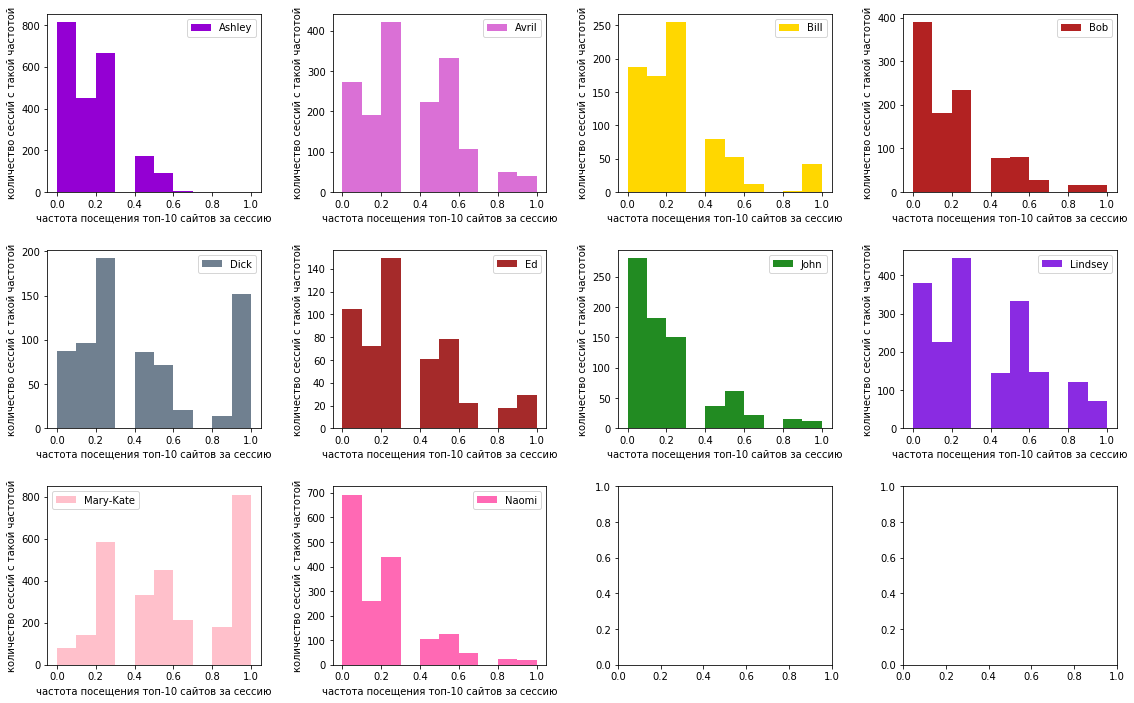

In [530]:
train_data_10u_new_fe[0]['target'] = train_data_10u_new_fe[0]['target'].map(id_name_dict)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10u_new_fe[0], 'target')): 
     plt.subplot(3, 4, idx + 1)
     #print(sub_df['top_10_freq'].values)
     plt.hist(sub_df['top_10_freq'].values, color = color_dic[user])
     plt.legend((user,))
     plt.xlabel('частота посещения топ-10 сайтов за сессию')
     plt.ylabel('количество сессий c такой частотой')
plt.tight_layout()
#''' ВАШ КОД ЗДЕСЬ ''' 

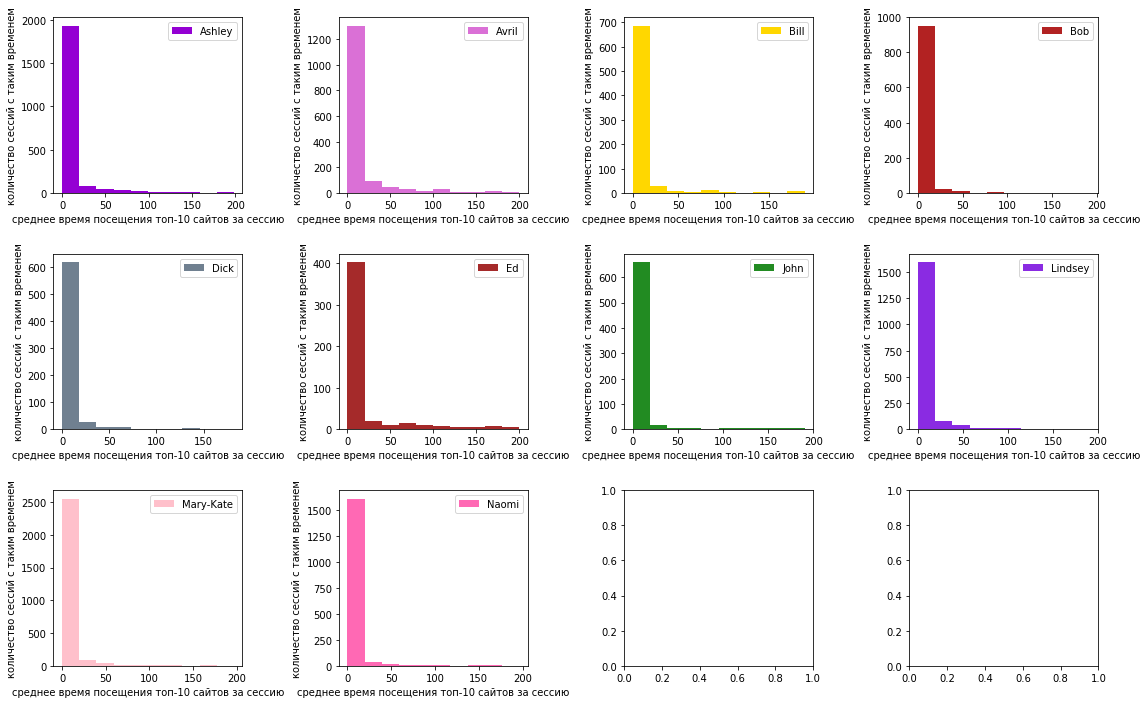

In [532]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10u_new_fe[0], 'target')): 
     plt.subplot(3, 4, idx + 1)
     #print(sub_df['top_10_freq'].values)
     plt.hist([x for x in sub_df['top_10_time'].values if x <= 200], color = color_dic[user])
     plt.legend((user,))
     plt.xlabel('среднее время посещения топ-10 сайтов за сессию')
     plt.ylabel('количество сессий c таким временем')
plt.tight_layout()

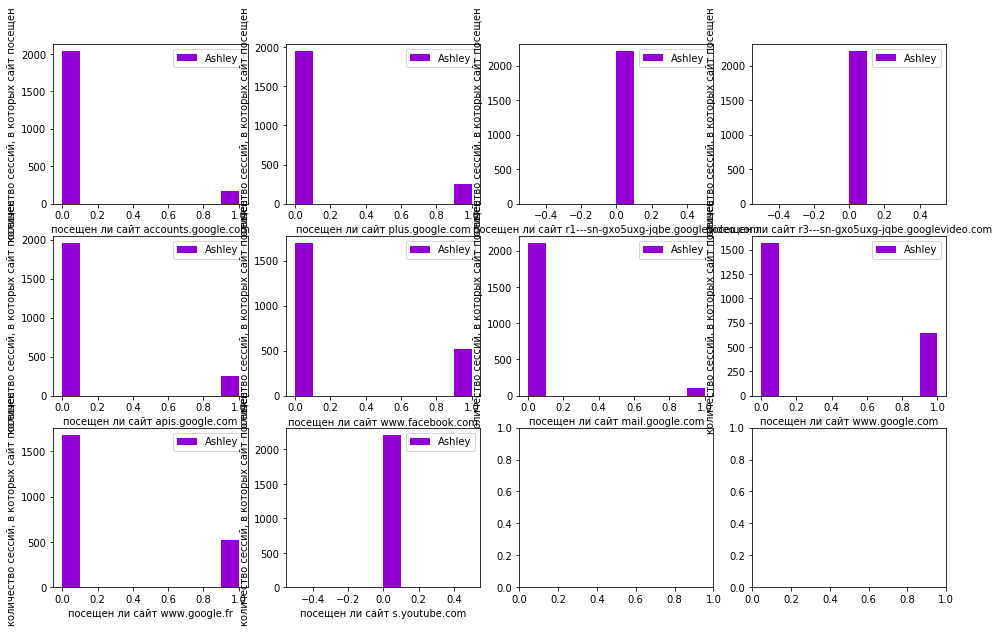

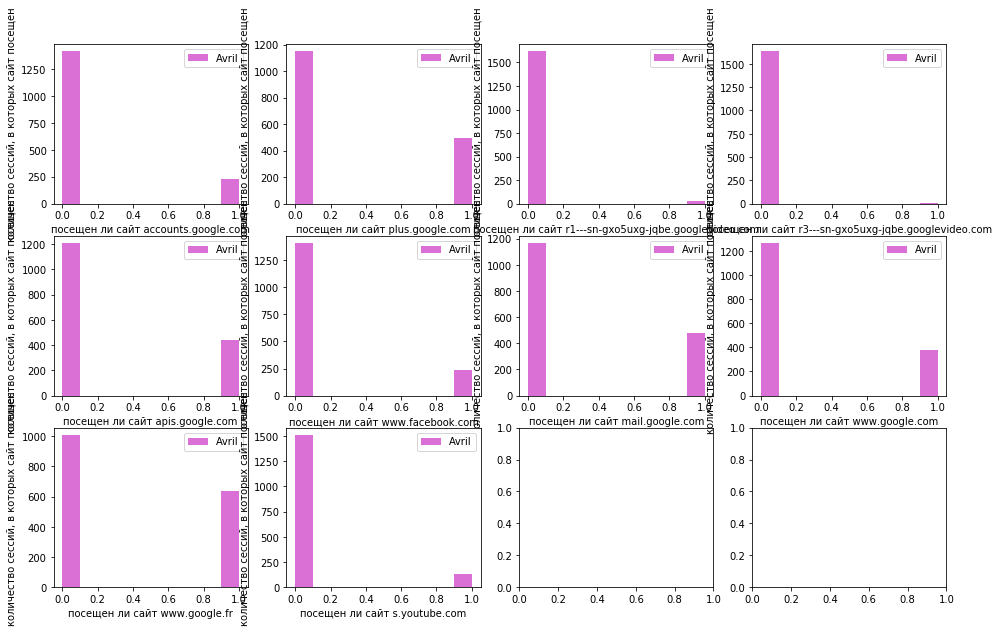

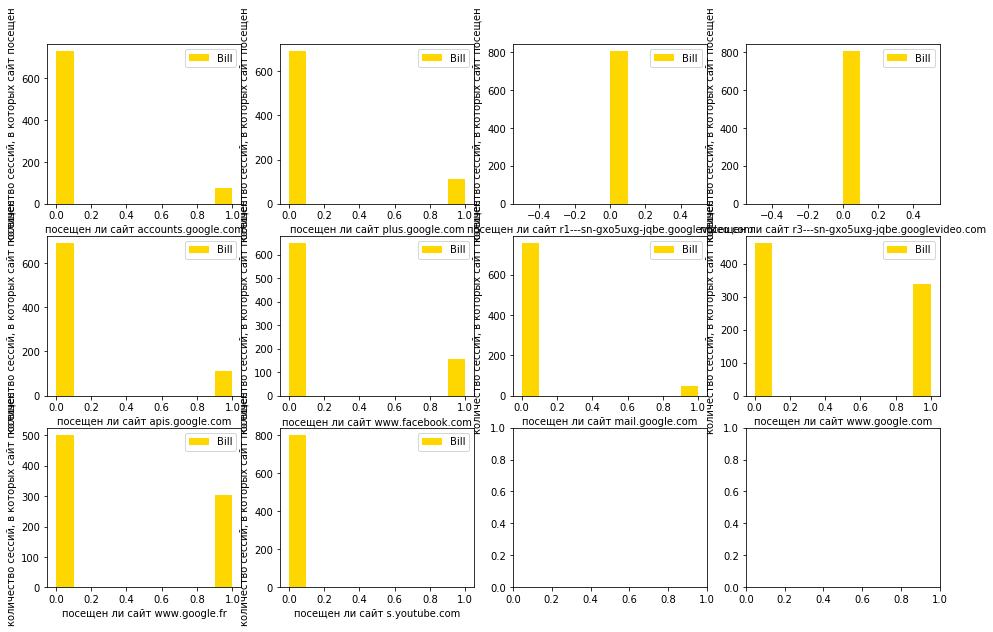

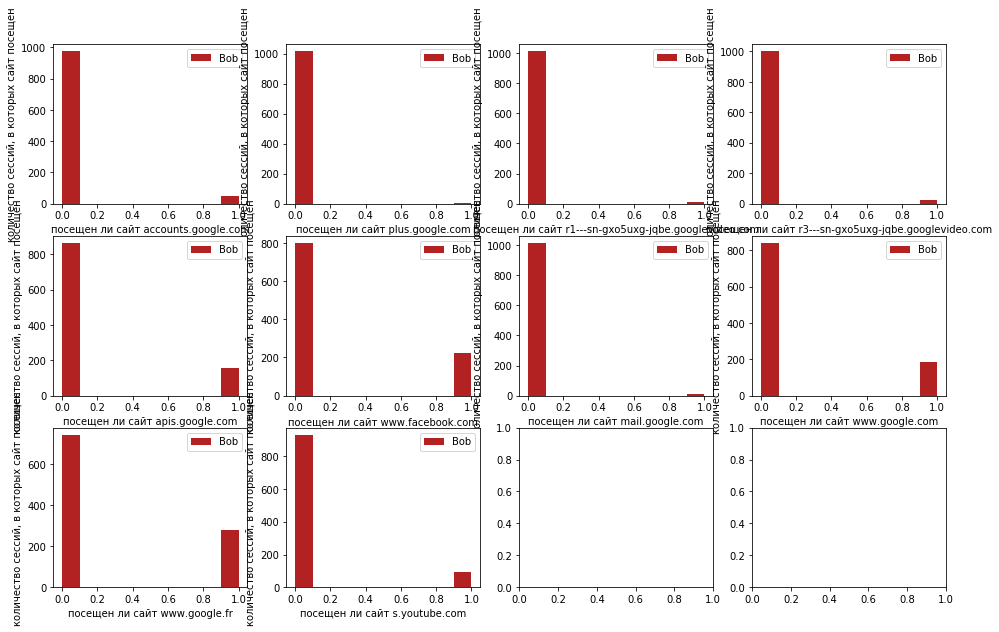

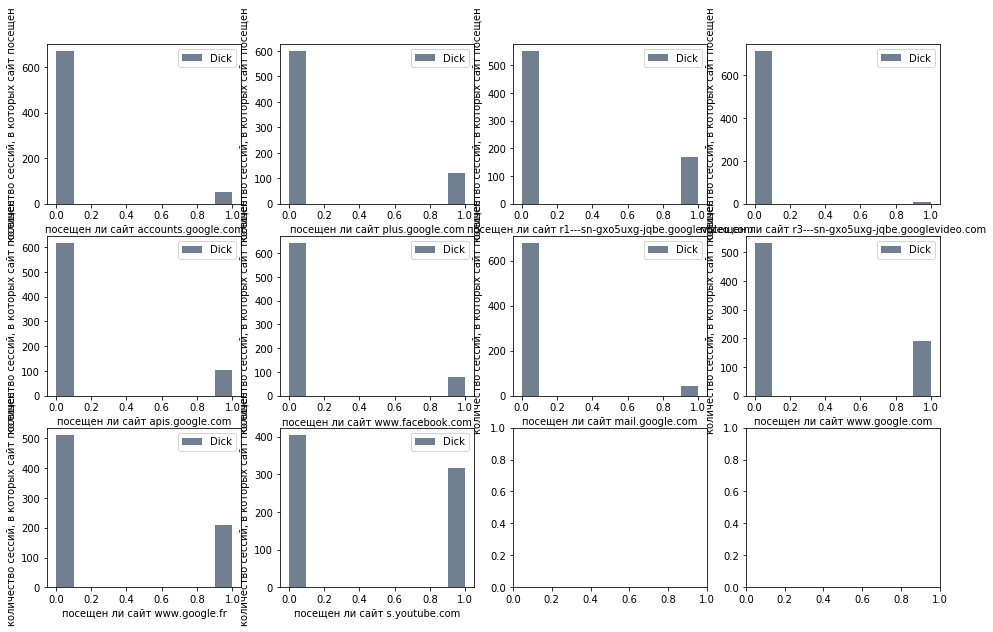

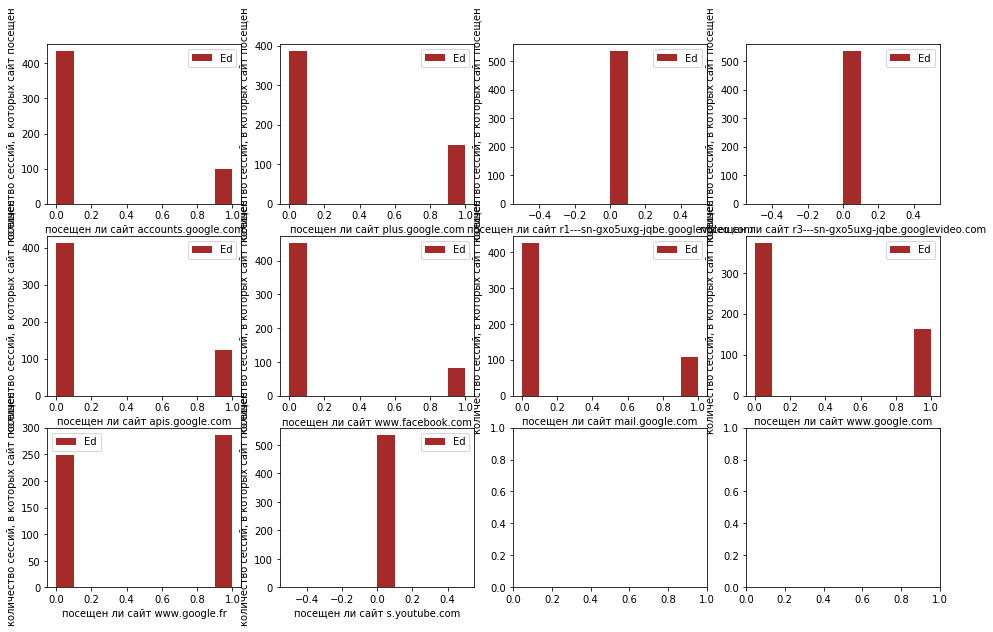

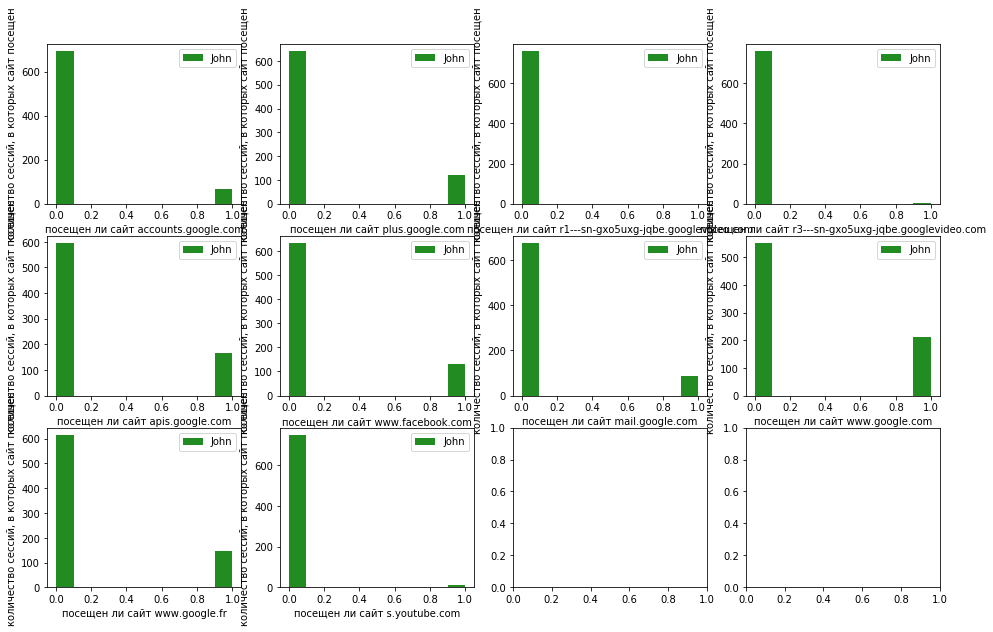

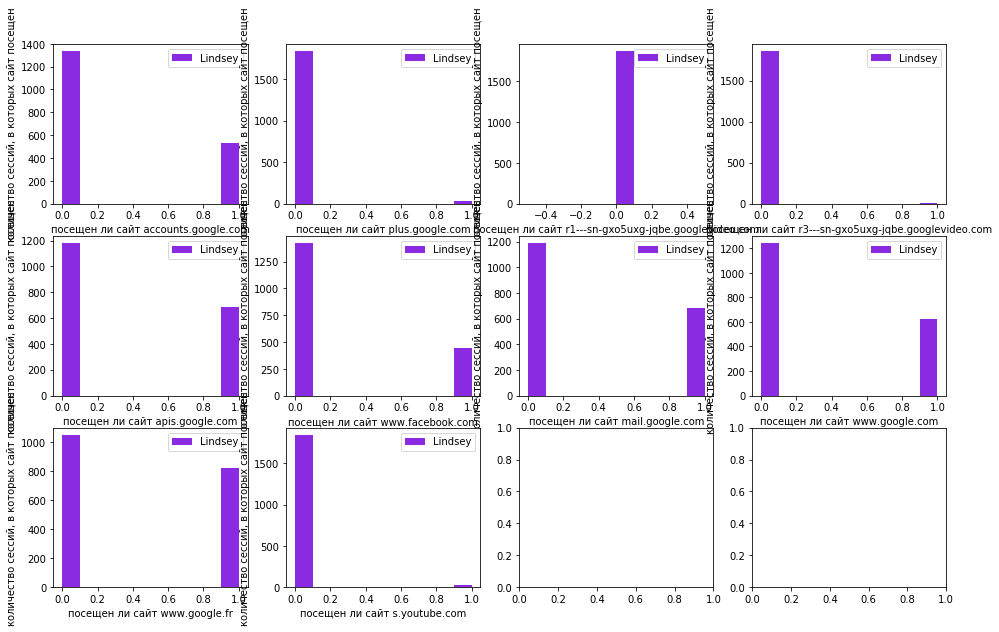

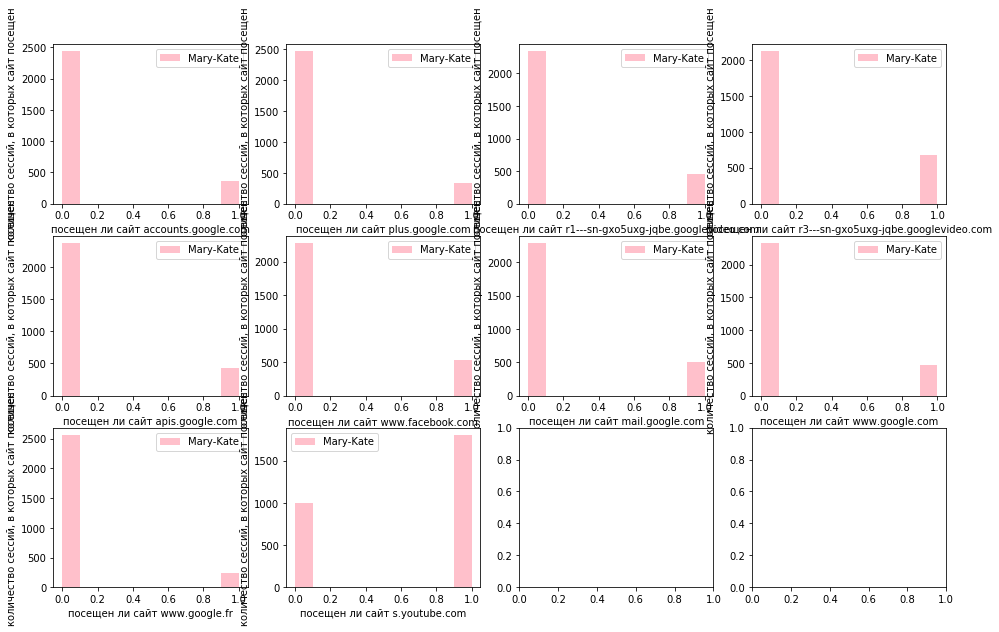

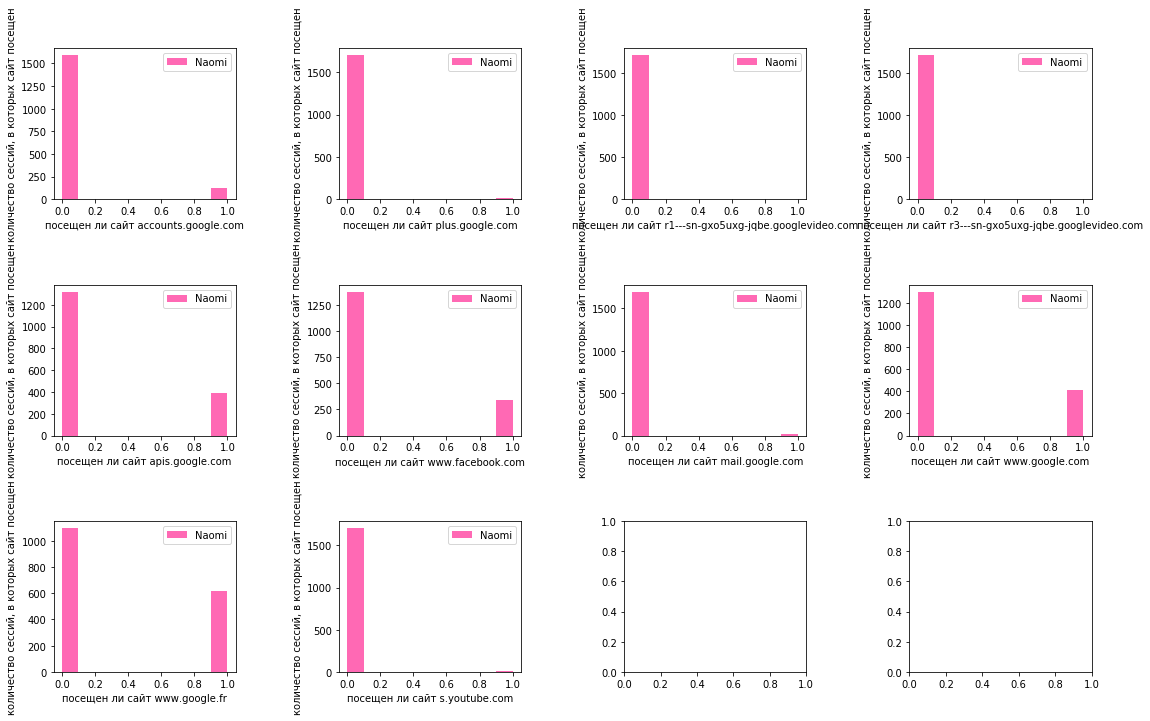

In [537]:


# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10u_new_fe[0], 'target')): 
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
    for i, colname in enumerate(train_data_10u_new_fe[0].columns[-11: -1]):
         plt.subplot(3, 4, i + 1)
     #print(sub_df['top_10_freq'].values)
         plt.hist(sub_df[colname].values, color = color_dic[user])
         plt.legend((user,))
         plt.xlabel('посещен ли сайт ' + colname)
         plt.ylabel('количество сессий, в которых сайт посещен')
plt.tight_layout()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [539]:
train_data_10u_new_fe[0][['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'top_10_freq'] + \
        [i for i in sites_names]]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,day_of_week,top_10_freq,accounts.google.com,plus.google.com,r1---sn-gxo5uxg-jqbe.googlevideo.com,r3---sn-gxo5uxg-jqbe.googlevideo.com,apis.google.com,www.facebook.com,mail.google.com,www.google.com,www.google.fr,s.youtube.com
session_id,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,...,4.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2.0,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,...,4.0,0.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4.0,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,...,4.0,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6.0,31.0,30.0,27.0,27.0,14.0,14.0,32.0,33.0,34.0,35.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,36.0,2.0,3.0,4.0,3.0,10.0,3.0,11.0,1.0,3.0,347099.0,0.0,...,4.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8.0,37.0,38.0,39.0,11.0,14.0,4.0,14.0,4.0,22.0,23.0,2.0,5.0,...,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9.0,14.0,17.0,40.0,5.0,41.0,42.0,14.0,43.0,40.0,15.0,1.0,0.0,...,1.0,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [541]:
selected_features_10users = train_data_10u_new_fe[0][['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'top_10_freq'] + \
        [i for i in sites_names]]
selected_features_150users = new_features_150users[0][['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'top_10_freq'] + \
        [i for i in sites_names]] 

In [542]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 